# Extract Envelope 

### Imports

In [1]:
from aubio import source, onset
import soundfile as sf
import numpy as np
from scipy import signal as sig
import librosa
import matplotlib.pyplot as plt
import IPython.display as ipd

In [21]:
def three_step_envelope(signal, K=200, freq_cutoff=0.125, padlen=150):
    # Take the absolute value of the signal
    abs_signal = np.abs(signal)

    # Split signal into K bunches of N/K samples and take the max
    # value from each bunch
    N = len(abs_signal)
    peaks = []
    for i in range(0, N, K):
        peaks.append(np.max(abs_signal[i:i+K]))
    peaks = np.asarray(peaks)

    # Apply a LPF with a cut off of 0.125 Times the Niquist (125 Hz)
    b, a = sig.butter(8, freq_cutoff)
    lpf_peaks = sig.filtfilt(b, a, peaks, padlen=padlen)
    
    return lpf_peaks

[5]
{'attack': 0.0009750566893424037, 'decay': 6.303854875283447, 'sustain': (0.0, 0.02197252746963543), 'release': 9.024943310657596}


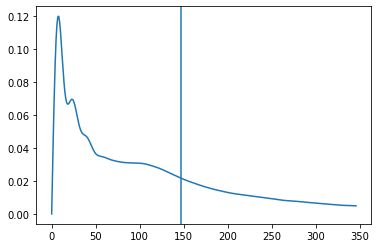

In [27]:
def err(p, q):
    return np.abs(p-q)

def sustain_end_idx(env_seg, hop_size=2, win_size=5, conf=0.1):
    offsets = np.arange(0, len(env_seg), hop_size)
    
    for o in offsets[:-1]: 
        frame = env_seg[o:o+win_size] 
        next_frame = env_seg[o+hop_size:o+hop_size+win_size]
        frame_area = np.trapz(frame)
        next_frame_area = np.trapz(next_frame)
        if err(frame_area, next_frame_area) > conf:
            return o
        
    return offsets[-1]
        
def find_nearest(array, value, min=0):
    return min + (np.abs(array - value)).argmin()

def attack(signal, onset, sr):
    '''
    Computes attack time by taking the difference 
    of the argmax and onset and dividing by the sampling rate
    '''
    return (np.argmax(np.abs(signal)) - onset)/sr

def find_first_onset(signal, K=200):
    onsets = []
    while len(onsets) == 0: 
        approx_env = three_step_envelope(signal=signal, K=K)
        # convert envelope to Fortran-contiguous
        ftrn_env = np.asfortranarray(approx_env) 

        onsets = librosa.onset.onset_detect(y=ftrn_env, sr=sr)
        print(onsets)
        K-=10
    
    return onsets[0]

def extract_envelope(signal, sr):
    '''
    Computes attack time, decay time (time to reach sustain powerlevel),
    sustain (time and powerlevel), and release time
    
    Returns Dictionary of the following format:
    
    {
        "attack": attack_time,
        "decay": decay_time,
        "sustain": (sustain_time, sustain_power),
        "release": release_time,
    }
    '''
    K = 200
    approx_env = three_step_envelope(signal=signal, K=K)
    # convert envelope to Fortran-contiguous
    ftrn_env = np.asfortranarray(approx_env) 
    
    first_onset = find_first_onset(signal)
    attack_t = attack(ftrn_env, first_onset, sr)
    
#     plt.plot(approx_env)
#     obtain a smooth approximation of the audio envelope
    K = 2000
    approx_env = three_step_envelope(signal=signal, K=K, padlen=50)
    plt.plot(approx_env)
    
#     Define decay as the time taken for the envelope's power level
#     to reduce to its average 
    max_idx = np.argmax(approx_env)
    mean = np.mean(approx_env)
    idx_nearest_to_mean = find_nearest(approx_env, mean, max_idx)
    decay_t = (idx_nearest_to_mean - max_idx)*K/sr
    plt.axvline(x=idx_nearest_to_mean)
    sustain_power = approx_env[idx_nearest_to_mean]
    
    sustain_len = sustain_end_idx(approx_env[:idx_nearest_to_mean])
    sustain_time = sustain_len*K/sr
    
#     assumes the end of the envelope is the end of the sustain
    release_time = (len(approx_env)-1 - (idx_nearest_to_mean+sustain_len))*K/sr

    return {
        "attack": attack_t,
        "decay": decay_t,
        "sustain": (sustain_time, sustain_power),
        "release": release_time,
    }

fname = '../datasets/guitar/open-e.wav'
env = extract_envelope(signal, sr)
print(env)
# ipd.Audio(signal,rate=sr)


## Test Driver Code

[5]
{'attack': 0.0009750566893424037, 'decay': 6.303854875283447, 'sustain': (0.0, 0.02197252746963543), 'release': 9.024943310657596}


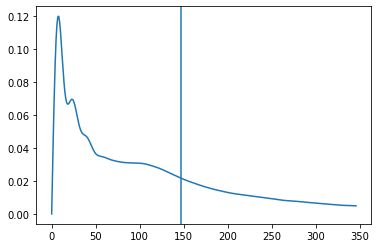

In [25]:
fname = '../datasets/guitar/vibrato.wav'
fname = '../datasets/guitar/open-e.wav'
signal, sr = sf.read(fname)
env = extract_envelope(signal, sr)
print(env)
